In [1]:
import pygplates
#import pmagpy.ipmag as ipmag
import numpy as np
import pandas as pd
import geopandas as gpd
from gprm.utils import pmag
from gprm.datasets import Reconstructions
from gprm import MotionPathFeature
import pygmt

from shapely.geometry import LineString, Polygon, Point

%load_ext autoreload
%autoreload 2

<AxesSubplot:>

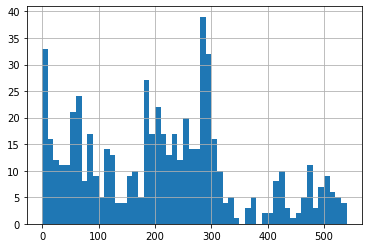

In [2]:
vgps_gdf = pmag.vgp_to_dataframe('/Users/simon/GIT/reconstruction_china/pmag/T2012_Mer21.gpml')
#vgps_gdf = vgps_gdf.drop(columns='PlateID')

vgps_gdf['AverageAge'].hist(bins=np.arange(0,550,10)) #.plot()


In [3]:
TC2017 = Reconstructions.fetch_TorsvikCocks2017()
M2021 = Reconstructions.fetch_Merdith2021()

TC2017

Name: Torsvik+Cocks2017
Rotation Files:
   - Torsvik_Cocks_HybridRotationFile.rot
Static Polygon Files:
   - CEED6_MICROCONTINENTS.shp
   - CEED6_LAND.gpml
Coastlines Files:
   - CEED6_LAND.gpml
Continent Polygon Files:
   - CEED6_LAND.gpml
   - CEED6_TERRANES.shp
   - CEED6_MICROCONTINENTS.shp
Dynamic Polygon Files:

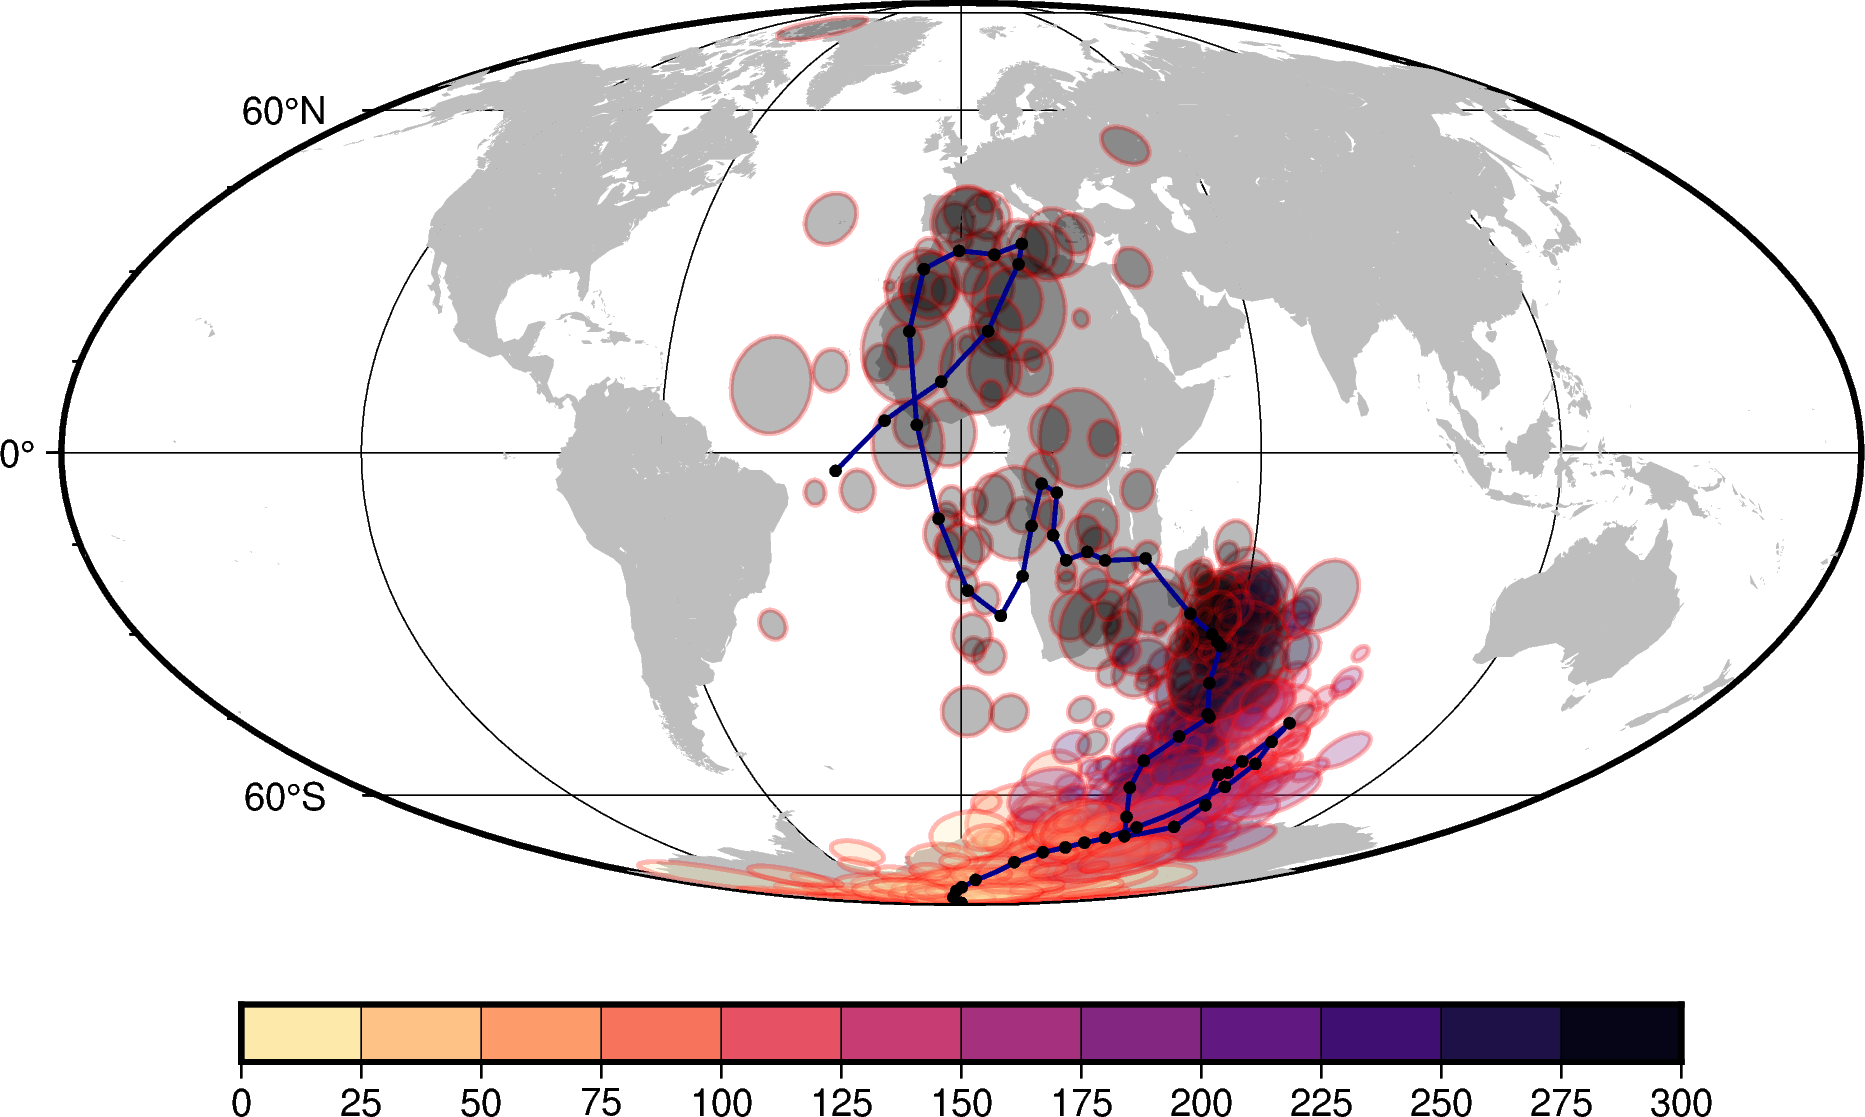

In [24]:
#T2012_vgps_gdf = pmag.assign_plate_ids(T2012_vgps_gdf, TC2017)
reconstruction_model = TC2017


path_times=np.arange(0.,541.,10.)
GAPWaP = MotionPathFeature(seed_points=(-90, 0), path_times=path_times, reconstruction_plate_id=1, relative_plate_id=701).reconstruct_motion_path(reconstruction_model)[0]
GAPWaP = gpd.GeoDataFrame(pd.DataFrame(data={'Age':path_times[::-1]}), geometry=gpd.points_from_xy(GAPWaP[:,1], GAPWaP[:,0]), crs=4326)


vgps_gdf = pmag.vgp_to_dataframe('/Users/simon/GIT/reconstruction_china/pmag/T2012_Mer21.gpml')

vgps_gdf = reconstruction_model.assign_plate_ids(vgps_gdf, polygons='static')

#T2012_vgps_gdf

rpoles = pmag.rotate_to_common_reference(vgps_gdf, reconstruction_model, reference_plate_id=701)

#rpoles

path = pmag.generate_running_mean_path(rpoles, np.arange(0,540,10), time_window=20.)

#path



fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='afg')
fig.coast(land='grey')
pygmt.makecpt(cmap='magma', series=[0,320,25], reverse=True)
fig.plot(x=rpoles.PoleLongitude, y=rpoles.PoleLatitude, size=rpoles.PoleA95*111.,
         style='E-', pen='1.0p,red', color=rpoles.AverageAge, cmap=True, t=85)
#fig.plot(x=path.PoleLongitude, y=path.PoleLatitude, size=path.PoleA95*111.,
#         style='E-', pen='1.0p,red', color=path.Age, cmap=True, t=70)
fig.plot(x=GAPWaP.geometry.x, y=GAPWaP.geometry.y, pen='1p,darkblue')
fig.plot(x=GAPWaP.geometry.x, y=GAPWaP.geometry.y, style='c0.1c', color='black')
#fig.plot(x=path.PoleLongitude, y=path.PoleLatitude, pen='1p,darkblue')
#fig.plot(x=path.PoleLongitude, y=path.PoleLatitude, style='c0.1c', color='black')
fig.colorbar()
fig.show(width=600)


In [10]:
from gprm.utils.create_gpml import gpml2gdf

def apply_rotation(features, lat, long, angle, vgps=False, return_type='gdf'):
    
    rotation = pygplates.FiniteRotation((lat,long), np.radians(angle))
    
    if isinstance(features, pygplates.FeatureCollection):
        rotated_features = []
        for feature in features:
            if feature.get_all_geometries():
                for geometry in feature.get_all_geometries():
                    print
                    f = pygplates.Feature()
                    f.set_geometry(rotation * geometry)
                    rotated_features.append(f)

        return rotated_features

    elif isinstance(features, gpd.GeoDataFrame):
        
        if not vgps:
            features = features[features.geometry.is_valid]   # remove invalid geometries
            features = features.explode()   # multipart to singlepart
            features.reset_index(inplace=True)   # reset index
        
        rotated_gdf = features.copy()
        
        for i,feature in features.iterrows():
            if vgps:
                geometry = pygplates.PointOnSphere(feature.PoleLatitude, feature.PoleLongitude)
            # Point features not handled yet
            elif feature.geometry.geom_type in ['LineString']:
                geometry = pygplates.PolylineOnSphere([(lat,lon) for lat,lon in zip(feature.geometry.xy[1], feature.geometry.xy[0])])
            elif feature.geometry.geom_type in ['Polygon']:
                # clearly this isn't handling interior rings
                geometry = pygplates.PolygonOnSphere([(lat,lon) for lat,lon in zip(feature.geometry.exterior.coords.xy[1], 
                                                                                   feature.geometry.exterior.coords.xy[0])])
            elif feature.geometry.geom_type in ['Point']:
                geometry = pygplates.PointOnSphere([feature.geometry.y, feature.geometry.x])
                
            rotated_geometry = rotation * geometry
        
            if vgps:
                rotated_gdf.loc[i, 'PoleLatitude'] = rotated_geometry.to_lat_lon()[0]
                rotated_gdf.loc[i, 'PoleLongitude'] = rotated_geometry.to_lat_lon()[1]
            else:
                if feature.geometry.geom_type in ['LineString']:
                    geom = LineString([tuple(coord[::-1]) for coord in rotated_geometry.to_lat_lon_list()])
                elif feature.geometry.geom_type in ['Polygon']:
                    geom = Polygon([tuple(coord[::-1]) for coord in rotated_geometry.to_lat_lon_list()])
                else:
                    geom = Point((rotated_geometry.to_lat_lon()[1], rotated_geometry.to_lat_lon()[0]))
                rotated_gdf.loc[i, 'geometry'] = geom
            
        return rotated_gdf
    
    
def rotated_graticule(lat,lon,angle,lat_spacing=30, lon_spacing=60, return_type='gdf'):
    
    rotation = pygplates.FiniteRotation((lat,lon), np.radians(angle))

    latitude_lines = []
    longitude_lines = []
    for lat in np.arange(-80,90,10):
        f = pygplates.Feature()
        geometry = rotation * pygplates.PolylineOnSphere(zip(np.ones(360)*lat, np.arange(0,361,1)))
        f.set_geometry(geometry)
        latitude_lines.append(f)
    for lon in np.arange(0,361,30):
        f = pygplates.Feature()
        geometry = rotation * pygplates.PolylineOnSphere(zip(np.arange(-90,91,1), np.ones(180)*lon))
        f.set_geometry(geometry)
        longitude_lines.append(f)
        
    return longitude_lines, latitude_lines



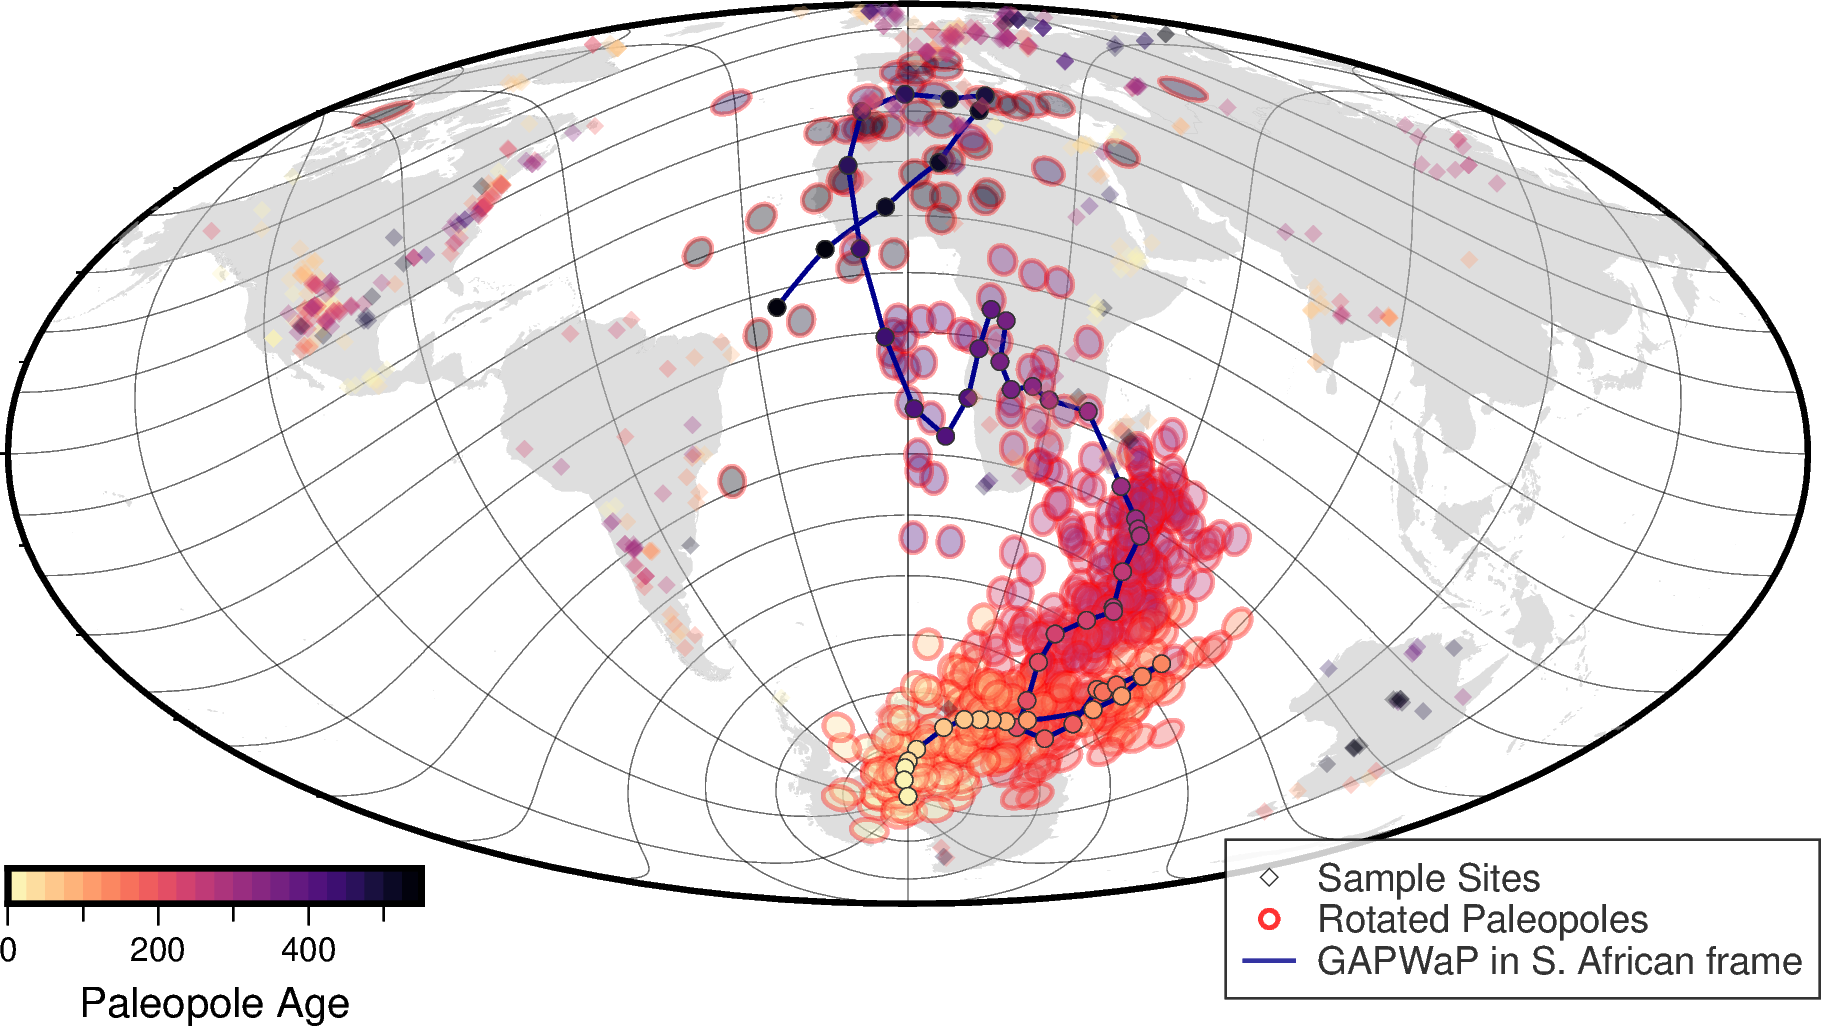

In [30]:
#rotation_

longitude_lines, latitude_lines = rotated_graticule(0,90,-30)
rcontinents = apply_rotation(gpd.read_file('/Users/simon/Data/GIS/continent.shp'), 0, 90, -30)
rrpoles = apply_rotation(rpoles, 0, 90, -30, vgps=True)
rsamples = apply_rotation(vgps_gdf, 0, 90, -30)
rpath = apply_rotation(gpd.GeoDataFrame(path, geometry=gpd.points_from_xy(path.PoleLongitude, path.PoleLatitude), crs=4326), 0, 90, -30)
rGAPWaP = apply_rotation(GAPWaP, 0, 90, -30)


fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='f')
#fig.coast(land='grey')

# Graticule
fig.plot(data=gpml2gdf(pygplates.FeatureCollection(latitude_lines)), pen='0.2p,black', transparency=40)
fig.plot(data=gpml2gdf(pygplates.FeatureCollection(longitude_lines)), pen='0.2p,black', transparency=40)

# dummy points for legend
fig.plot(x=0, y=-60, style='d0.15c', label='Sample Sites')
fig.plot(x=0, y=-60, style='E-', size=[2.], pen='1.0p,red', label='Rotated Paleopoles')


# rotated (present-day) continent polygons
fig.plot(data=rcontinents, color='gray', transparency=50)

# Rotated VGPs
pygmt.makecpt(cmap='magma', series=[0,550,25], reverse=True)
#fig.plot(x=rrpoles.PoleLongitude, y=rrpoles.PoleLatitude, size=rrpoles.PoleA95*111.,
#         style='E-', pen='1.0p,red', color=rrpoles.AverageAge, cmap=True, t=90)
fig.plot(x=rrpoles.PoleLongitude, y=rrpoles.PoleLatitude, size=np.ones(len(rrpoles))*555.,
         style='E-', pen='1.0p,red', color=rrpoles.AverageAge, cmap=True, t=80)


# APWP
#fig.plot(x=rpath.geometry.x, y=rpath.geometry.y, pen='1p,darkblue', label='GAPWaP in S. African frame')
#fig.plot(x=rpath.geometry.x, y=rpath.geometry.y, style='c0.15c', color=path.Age, cmap=True, pen='0.25p,gray20')

fig.plot(x=rGAPWaP.geometry.x, y=rGAPWaP.geometry.y, pen='1p,darkblue', label='GAPWaP in S. African frame')
fig.plot(x=rGAPWaP.geometry.x, y=rGAPWaP.geometry.y, style='c0.15c', color=GAPWaP.Age, cmap=True, pen='0.25p,gray20')


# Sample Sites
fig.plot(x=rsamples.geometry.x, y=rsamples.geometry.y, style='d0.15c', color=rsamples.AverageAge, cmap=True, 
         transparency=70)

with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBL+jBL+o0.0c+w3.5c/0.3c+h', frame=['x+lPaleopole Age'])#, box='+gwhite+p0.5p')
fig.legend(transparency=20, position='JBR+jBR+o-0.1c/-0.8c', box='+gwhite+p0.5p')

fig.savefig('./GAPWAP.pdf')
fig.show(width=1000)


In [9]:
'''
#T2012_vgps_gdf = pmag.assign_plate_ids(T2012_vgps_gdf, TC2017)
reconstruction_model = TC2017
reconstruction_time = 150.


vgps_gdf = pmag.vgp_to_dataframe('/Users/simon/GIT/reconstruction_china/pmag/T2012_Mer21.gpml')

vgps_gdf = reconstruction_model.assign_plate_ids(vgps_gdf, polygons='static')


for reconstruction_time in np.arange(530,-1,-10):
    path_times=np.arange(0.,541.,10.)
    GAPWaP = MotionPathFeature(seed_points=(-90, 0), 
                               path_times=path_times, 
                               reconstruction_plate_id=1, 
                               relative_plate_id=701).reconstruct_motion_path(reconstruction_model,
                                                                              reconstruction_time=reconstruction_time,
                                                                              anchor_plate_id=1)[0]




    #T2012_vgps_gdf

    rpoles = pmag.rotate_to_common_reference(vgps_gdf, reconstruction_model, reference_plate_id=701)
    rpoles['PLATEID1'] = 701

    #pmag.
    rrpoles = TC2017.reconstruct(rpoles, reconstruction_time=reconstruction_time)
    #rpoles


    fig = pygmt.Figure()
    fig.basemap(region='d', projection='W6i', frame='afg')
    #fig.coast(land='grey')
    TC2017.polygon_snapshot(polygon_type='continents', 
                            reconstruction_time=reconstruction_time,
                            anchor_plate_id=1).plot(fig)
    
    #pygmt.makecpt(cmap='magma', series=[0,320,25], reverse=True)
    #fig.plot(x=rrpoles.geometry.x, y=rrpoles.geometry.y, size=np.ones(len(rrpoles))*200.,
    #         style='E-', pen='1.0p,red', color=rpoles.AverageAge, cmap=True, t=85)
    
    #fig.plot(x=path.PoleLongitude, y=path.PoleLatitude, size=path.PoleA95*111.,
    #         style='E-', pen='1.0p,red', color=path.Age, cmap=True, t=70)

    fig.plot(x=GAPWaP[:,1], y=GAPWaP[:,0], pen='1p,dodgerblue')
    #fig.colorbar()
    fig.savefig('./plots/gapwap_{:0.0f}Ma.jpg'.format(reconstruction_time))
    #fig.show(width=1200)
'''

In [28]:
path_times[::-1]


array([540., 530., 520., 510., 500., 490., 480., 470., 460., 450., 440.,
       430., 420., 410., 400., 390., 380., 370., 360., 350., 340., 330.,
       320., 310., 300., 290., 280., 270., 260., 250., 240., 230., 220.,
       210., 200., 190., 180., 170., 160., 150., 140., 130., 120., 110.,
       100.,  90.,  80.,  70.,  60.,  50.,  40.,  30.,  20.,  10.,   0.])